# Full Model Training and Evaluation
This notebook compares SVM, Decision Tree, and Random Forest classifiers using Dow Jones Index data. It includes training, evaluation, generalization error analysis, and overfitting visualization.

##  Import Libraries

In [1]:
# Weekly stock movement prediction using Dow Jones Index data
# Models used: SVM, Decision Tree, Random Forest

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

# Load data (CSV input path may be needed)
df = pd.read_csv("dow_jones_index.data")


In [2]:
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


## Data Preprocessing

In [3]:
# Convert price columns to float after removing '$'
price_cols = ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']
for col in price_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

df

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,NaN,NaN,16.71,15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801
746,2,XOM,6/3/2011,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960
747,2,XOM,6/10/2011,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120
748,2,XOM,6/17/2011,80.00,80.82,78.33,79.02,100521400,-1.22500,8.811952,92380844.0,78.65,76.78,-2.377620,54,0.594786


In [4]:
# Create target variable: whether the stock price increases next week
# If percent_change_next_weeks_price > 0, label = 1; else 0
df['target_up'] = df['percent_change_next_weeks_price'].apply(lambda x: 1 if x > 0 else 0)

# Define feature list
features = [
    'open', 'high', 'low', 'close',
    'volume', 'percent_change_price',
    'percent_change_volume_over_last_wk',
    'days_to_next_dividend', 'percent_return_next_dividend'
]

# Remove missing values
df_model = df[features + ['target_up']].dropna()
df_model

,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,days_to_next_dividend,percent_return_next_dividend,target_up
1,16.71,16.71,15.64,15.97,242963398,-4.428490,1.380223,19,0.187852,0
2,16.19,16.38,15.60,15.79,138428495,-2.470660,-43.024959,12,0.189994,1
3,15.87,16.63,15.82,16.13,151379173,1.638310,9.355500,5,0.185989,1
4,16.18,17.39,16.18,17.14,154387761,5.933250,1.987452,97,0.175029,1
5,17.33,17.48,16.97,17.37,114691279,0.230814,-25.712195,90,0.172712,0
...,...,...,...,...,...,...,...,...,...,...
745,80.22,82.63,80.07,82.63,68230855,3.004240,-21.355713,75,0.568801,0
746,83.28,83.75,80.18,81.18,78616295,-2.521610,15.221032,68,0.578960,0
747,80.93,81.87,79.72,79.78,92380844,-1.420980,17.508519,61,0.589120,0
748,80.00,80.82,78.33,79.02,100521400,-1.225000,8.811952,54,0.594786,0


## Model Training (SVM, Decision Tree, Random Forest)

In [5]:
# Split into features (X) and target (y)
X = df_model[features]
y = df_model['target_up']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm = SVC(kernel='rbf')
svm.fit(X_train_scaled, y_train)

# Train Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Accuracy Evaluation

In [6]:
# Define function for prediction and evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name:15}: {acc:.4f}")

# Run accuracy evaluation
print("Classification Accuracy Comparison:")
evaluate_model(svm, X_test_scaled, y_test, "SVM")
evaluate_model(dt, X_test, y_test, "Decision Tree")
evaluate_model(rf, X_test, y_test, "Random Forest")

Classification Accuracy Comparison:
SVM            : 0.5069
Decision Tree  : 0.5278
Random Forest  : 0.5625


## Generalization Error Calculation

In [7]:
# Generalization error calculation function
def compute_generalization_error(model_name, val_error, complexity, n_train, Omega=0.05):
    gen_error = val_error + Omega * (complexity / n_train)
    return gen_error

# Number of training samples
n_train = len(X_train)

# SVM
svm_val_err = 1 - svm.score(X_test_scaled, y_test)
svm_complexity = len(svm.support_)
svm_gen_err = compute_generalization_error("SVM", svm_val_err, svm_complexity, n_train)

# Decision Tree
dt_val_err = 1 - dt.score(X_test, y_test)
dt_complexity = dt.get_depth()
dt_gen_err = compute_generalization_error("Decision Tree", dt_val_err, dt_complexity, n_train)

# Random Forest
rf_val_err = 1 - rf.score(X_test, y_test)
rf_complexity = sum(tree.get_depth() for tree in rf.estimators_) / len(rf.estimators_)
rf_gen_err = compute_generalization_error("Random Forest", rf_val_err, rf_complexity, n_train)

# Result output
print("Generalization Error Comparison:")
print(f"SVM:            {svm_gen_err:.4f}")
print(f"Decision Tree:  {dt_gen_err:.4f}")
print(f"Random Forest:  {rf_gen_err:.4f}")

Generalization Error Comparison:
SVM:            0.5392
Decision Tree:  0.4742
Random Forest:  0.4391


## Tree Visualization  
Inspect full and leaf-level structures of Decision Tree and Random Forest.

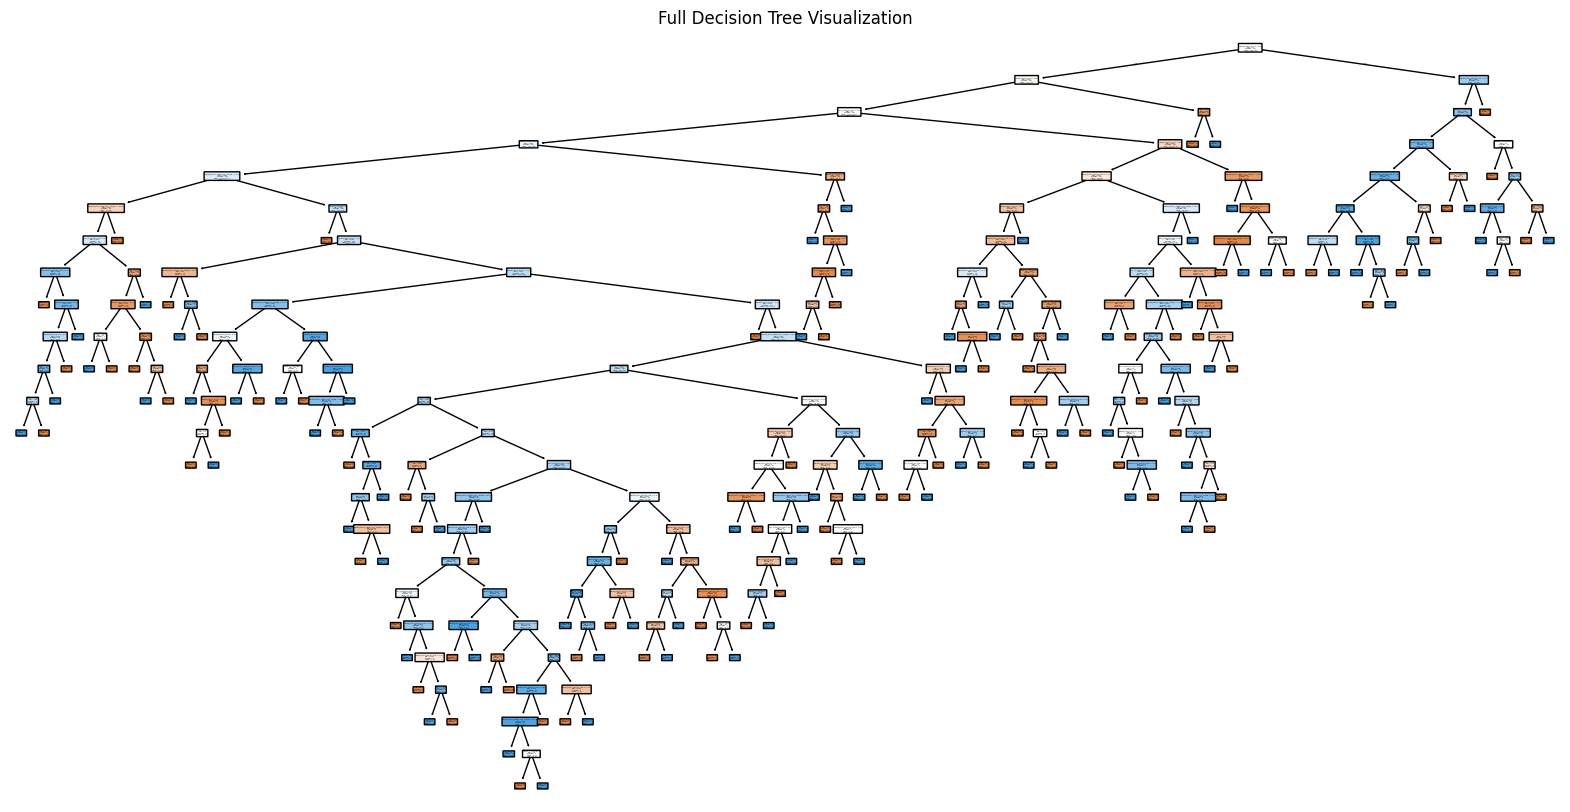

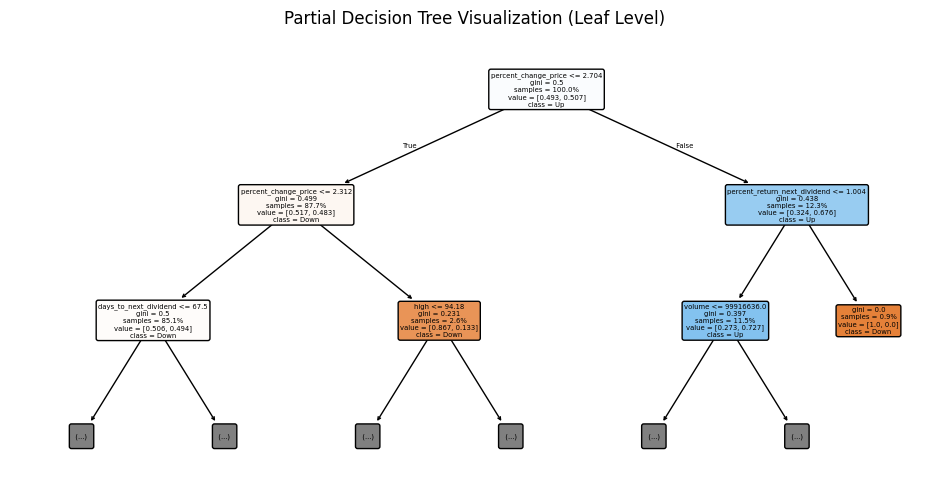

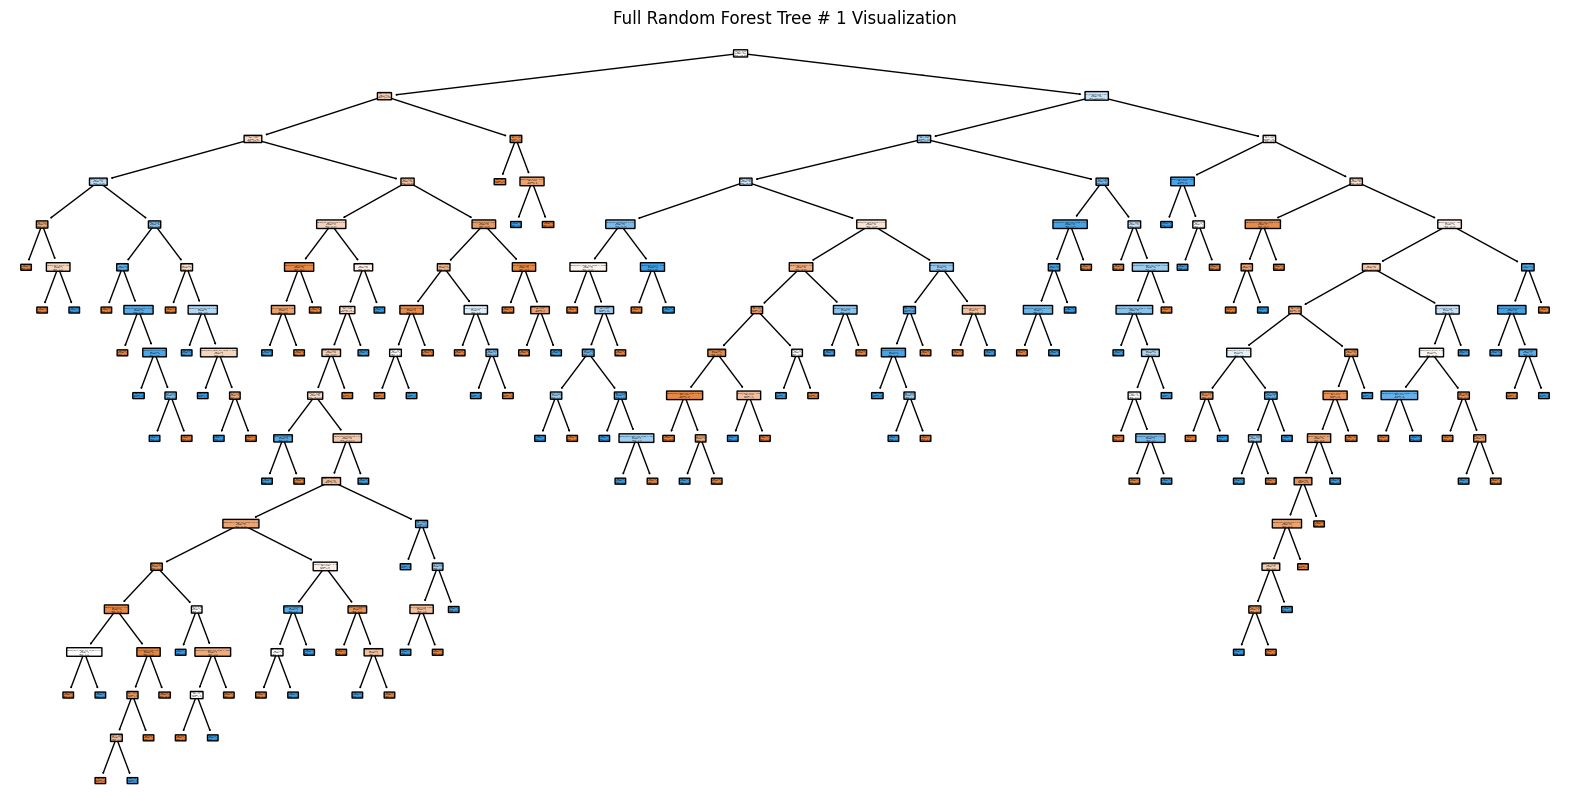

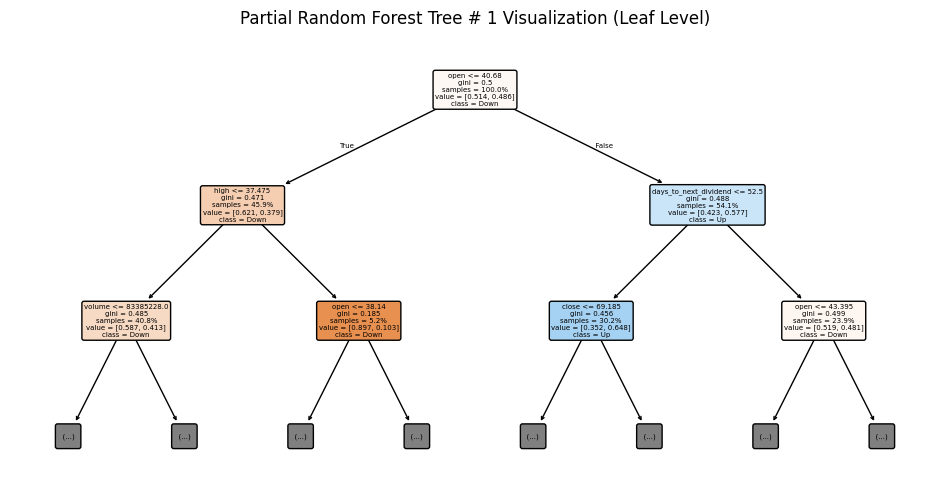

In [8]:
# Decision Tree and Random Forest Visualize leaf-level nodes in Decision Tree and Random Forest


# Decision Tree Full tree visualization
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=["Down", "Up"], filled=True, rounded=True)
plt.title("Full Decision Tree Visualization")
plt.show()

# Decision Tree Partial tree visualization with depth limit
plt.figure(figsize=(12, 6))
plot_tree(dt, feature_names=X.columns, class_names=["Down", "Up"], filled=True, rounded=True, max_depth=2, proportion=True)
plt.title("Partial Decision Tree Visualization (Leaf Level)")
plt.show()

# Random Forest - Visualization of first tree in the Random Forest
first_tree = rf.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(first_tree, feature_names=X.columns, class_names=["Down", "Up"], filled=True, rounded=True)
plt.title("Full Random Forest Tree # 1 Visualization")
plt.show()

# Random Forest - first tree Partial tree visualization with depth limit
plt.figure(figsize=(12, 6))
plot_tree(first_tree, feature_names=X.columns, class_names=["Down", "Up"], filled=True, rounded=True, max_depth=2, proportion=True)
plt.title("Partial Random Forest Tree # 1 Visualization (Leaf Level)")
plt.show()

## Analyzing Tree Depth and Overfitting  
Inspect the actual tree depth and plot error rates to verify if the trained depth (e.g., 23) achieves a good balance without overfitting.

Actual depth of the Decision Tree: 23






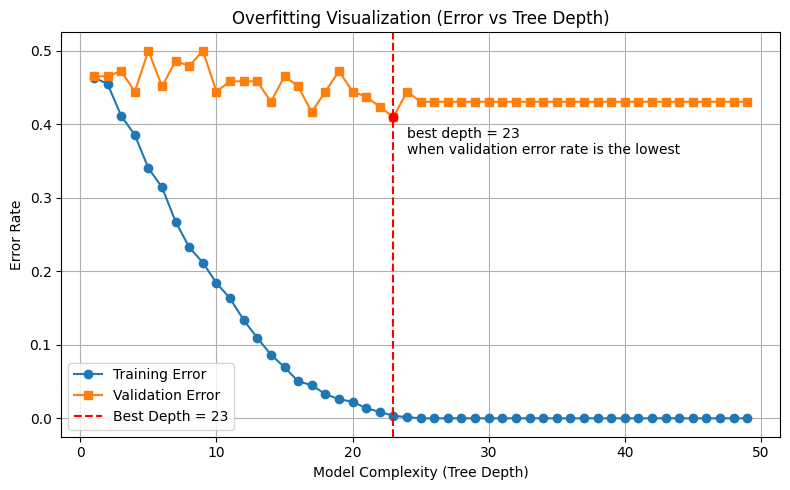

In [9]:
# Print the actual depth of the trained Decision Tree
print("======================================================================")
print("Actual depth of the Decision Tree:", dt.get_depth())
print("======================================================================")
print("\n")
print("\n")


# Plot training and validation error rates to identify the appropriate model complexity
# that avoids overfitting while maintaining good generalization performance

# Vary tree depth and record training/validation error
depths = list(range(1, 50))
train_errors = []
val_errors = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=0)
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    val_error = 1 - model.score(X_test, y_test)
    train_errors.append(train_error)
    val_errors.append(val_error)

# Find best depth and minimum validation error
best_depth = depths[np.argmin(val_errors)]
min_val_error = min(val_errors)

# Visualization
plt.figure(figsize=(8, 5))
plt.plot(depths, train_errors, marker='o', label="Training Error")
plt.plot(depths, val_errors, marker='s', label="Validation Error")

# Highlight best point
plt.axvline(best_depth, color='red', linestyle='--', label=f"Best Depth = {best_depth}")
plt.scatter(best_depth, min_val_error, color='red', zorder=5)
plt.text(best_depth + 1, min_val_error - 0.05, f"best depth = {best_depth} \nwhen validation error rate is the lowest", color='black')

plt.xlabel("Model Complexity (Tree Depth)")
plt.ylabel("Error Rate")
plt.title("Overfitting Visualization (Error vs Tree Depth)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Printing a majority voting in random forest

In [10]:
# Analyze prediction process of Random Forest
# Collect predictions from individual trees in the Random Forest
rf_preds = []

# Convert X_test to NumPy array to avoid warnings
X_test_array = X_test.values

for tree in rf.estimators_:
    pred = tree.predict(X_test_array)  # Make predictions on the test data
    rf_preds.append(pred)  # Store predictions

# Convert list to NumPy array (shape: n_trees x n_samples)
rf_preds = np.array(rf_preds)

# Final prediction using majority voting
final_rf_pred = mode(rf_preds, axis=0, keepdims=False).mode

# Example: View predictions from all trees for the first sample
print("Predictions from each tree for the first test sample:\n", rf_preds[:, 0])
print("Majority vote prediction (final prediction):", final_rf_pred[0])
print("True label:", y_test.iloc[0])

Predictions from each tree for the first test sample:
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1.]
Majority vote prediction (final prediction): 1.0
True label: 0


## Inter-Tree Prediction Correlation in Random Forest  
Evaluates the degree of independence and Visualize the result as a heat map among individual decision trees in the Random Forest.  
A low average correlation indicates that the classifiers are relatively independent, which is desirable for ensemble diversity.

Average inter-tree correlation (excluding diagonal): 0.1031






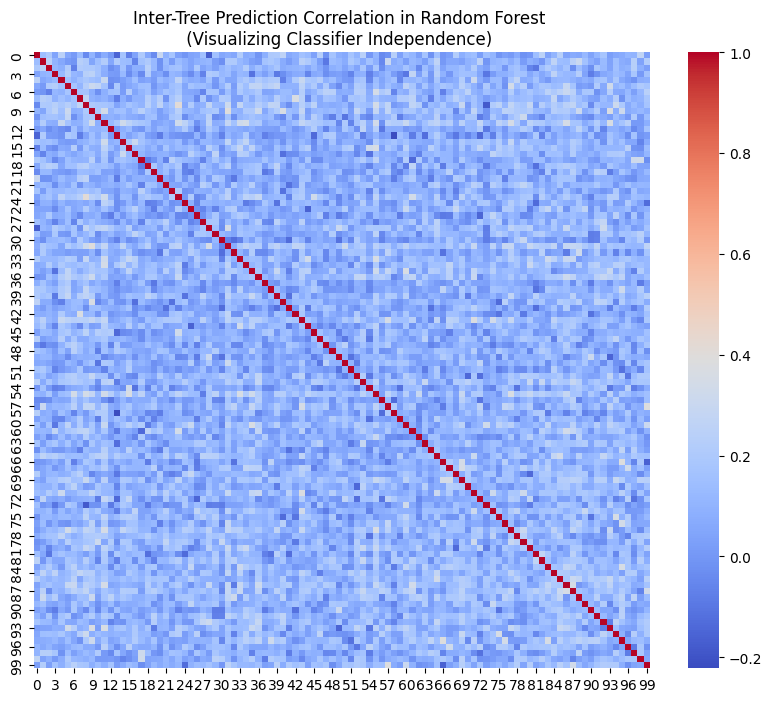

In [11]:
# Check prediction correlation among individual classifiers in Random Forest
# Check if classifiers are approximately independent
# Compute inter-classifier prediction correlation

rf_preds = []
X_test_array = X_test.values

for estimator in rf.estimators_:
    preds = estimator.predict(X_test_array)
    rf_preds.append(preds)

rf_preds = np.array(rf_preds)
correlation_matrix = np.corrcoef(rf_preds)

# Exclude diagonal (self-correlation) from correlation matrix
n_trees = correlation_matrix.shape[0]
mask = ~np.eye(n_trees, dtype=bool)
mean_corr = correlation_matrix[mask].mean()

# Result output
print("======================================================================")
print("Average inter-tree correlation (excluding diagonal):", round(mean_corr, 4))
print("======================================================================")
print("\n")
print("\n")


# Correlation heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", square=True)
plt.title("Inter-Tree Prediction Correlation in Random Forest \n (Visualizing Classifier Independence)  ")
plt.show()
